# Name : Pat O'Dowd

# Number : 8273375

# Description
Load a Resnet model and evaluate results based on synthetic shape data.

Test 1 – Checking Pre-Trained Model Base line


Test 2 – Checking Pre-trained model with synthetic data.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import time
import os
import numpy as np
import glob
import random
import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, models
from torchvision import utils
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, v2, Pad, Grayscale
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd

In [2]:
!pip install torchinfo
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
# Global Variables
HW_trg =224

# Common Functions

In [4]:

#imagenette_dict={0:'Tench Fish',217:'English Springer',482:'Casette Player',
#                491:'Chain Saw',497:'Church',566:'French Horn',
#                 569:'Garbage Truck',571:'Gas Pump',574:'Golfball',
#                 662:'Modem', 701:'Parachute',864:'Tow Truck', 867:'Trailer Truck'}

mean = [0.485, 0.456, 0.406]  # Example mean used for normalization
std = [0.229, 0.224, 0.225]   # Example std used for normalization

def unnormalize_image(image, mean, std):
    """
    Unnormalize a PyTorch image tensor.

    Args:
        image (torch.Tensor): The normalized image tensor of shape [C, H, W].
        mean (list or tuple): The mean used for normalization.
        std (list or tuple): The standard deviation used for normalization.

    Returns:
        torch.Tensor: The unnormalized image tensor.
    """
    # Remove the batch dimension
    image = image.squeeze(0)

    # Check if the image is in the shape [C, H, W]
    if image.dim() == 3:
        # Unnormalize the image
        for t, m, s in zip(image, mean, std):
            t.mul_(s).add_(m)
    else:
        raise ValueError("Expected image tensor of shape [C, H, W]")

    # Convert from [C, x, y] to [x, y, C]
    image = image.permute(1, 2, 0)
    return image

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
# ADDED - Added method to get prediction from image.
def getPrediction(image):


    pred_logit = model(image)
#    print(pred_logit)
    opFeatures = pred_logit['op_features']
    opLogits = pred_logit['op_logits']
    
#    predictions = torch.argmax(opLogits) # reduce along output dimension

    return opFeatures,opLogits

# ADDED - Added method to get class activation map
# Parameters are the features, logits,the number of TopN to return and also the topN class to select.

def getCAM(opFeatures,opLogits,topN,classIndex):

# Get the topN values and classes.
    values,curr_class = torch.topk(opLogits, topN)
    probabilities = nn.functional.softmax(opLogits, dim=1)
    
    batchSize,numChannels,Height,Width = opFeatures.shape
    selectedClass = curr_class[0][classIndex]
#    selectedValue = values[0][classIndex]
    selectedValue = probabilities[0][selectedClass] * 100

# Get the weights for the selected classs
    
    weights = sd['fc.weight'][selectedClass]

# Calculate the class activation map by 
# 1. Multiplying the weights by the features
# 2 Summing the weights
# 3 Reshaping back into an image vector 
# 4 upsammpling the image to its original size. 
    
    cam = weights.reshape(numChannels,1)*(opFeatures.reshape(numChannels,Height*Width))
    camSummed = torch.sum(cam,dim=0)
    camSummed = camSummed.reshape(1,1,Height,Width)
    upSample = torch.nn.Upsample(scale_factor=scaleFactor,mode='bilinear')
    act_map_us = upSample(camSummed).to("cpu").reshape(HW_trg,HW_trg,1)     

    return act_map_us,selectedClass,selectedValue
    
def get_value(dictionary, key):
    try:
        return dictionary[key]
    except KeyError:
        return "Error"

def plot_cam():

    fig = plt.figure(figsize=(12,12), frameon=False)

    fig.tight_layout()
# Iterate over the dataiter to produce a few examples
    
# Ensure model is eval mode to disable batch normalisation during inference.
    model.eval()
    j = 0
    scaleFactor = HW_trg/7
    for i in range(7):
        dataiter = iter(data_loader)
    
        z = next(dataiter)
        z_img = z[0].to(device)
        img = z[0]

        opFeatures,opLogits = getPrediction(z_img)

        topN = 4
        img=unnormalize_image(img,mean,std)
        ax = fig.add_subplot(7, 5, j + 1, xticks=[], yticks=[])
        ax.set_title('Original',fontsize=8)        
        ax.imshow(img)
        j= j+ 1
        for k in range(topN):
            topNImage = img
            act_map_us,curr_class,curr_value = getCAM(opFeatures,opLogits,topN,k)
# Use the imagenette labels from the resnet model for all classes.
            label = get_value(imagenette_labels,int(curr_class))
            label = label + " - " + str(int(curr_value))
            ax = fig.add_subplot(7, 5, j + 1, xticks=[], yticks=[])
            ax.set_title(label,fontsize=8)        
            ax.imshow(img)
            plt.imshow(img)
            plt.imshow(act_map_us.detach().numpy(), cmap=plt.cm.jet, alpha=0.4)
            j=j+1


    plt.show()
    return


def plot_cam_class(object_class):

    fig = plt.figure(figsize=(12,12), frameon=False)


# Iterate over the dataiter to produce a few examples
    
# Ensure model is eval mode to disable batch normalisation during inference.
    model.eval()
    j = 0
    scaleFactor = HW_trg/7
    for i in range(10000):
        dataiter = iter(data_loader)
    
        z = next(dataiter)
        z_img = z[0].to(device)
        img = z[0]

        opFeatures,opLogits = getPrediction(z_img)

        topN = 1
        img=unnormalize_image(img,mean,std)
        topNImage = img
        k=0
        act_map_us,curr_class,curr_value = getCAM(opFeatures,opLogits,topN,k)
# Use the imagenette labels from the resnet model for all classes.
        label = get_value(imagenette_labels,int(curr_class))
        if label == object_class:
            print(1,j,label)
            label = label + " - " + str(int(curr_value))
            ax = fig.add_subplot(4, 5, j + 1, xticks=[], yticks=[])
            ax.title.set_text(label)
            ax.imshow(img)
            plt.imshow(img)
            plt.imshow(act_map_us.detach().numpy(), cmap=plt.cm.jet, alpha=0.4)
            j=j+1


    plt.show()
    return


def generate_topn_distribution(top_distribution_dict,top5_distribution_dict,category,image_classes):


# Iterate over the dataiter to produce a few examples

    triangles = ['Triangles','C_Triangle','O_Triangle','OT_Triangle','K_Triangle','NK_Triangle','KC_Triangle']

# Ensure model is eval mode to disable batch normalisation during inference.
    model.eval()
    j = 0
    scaleFactor = HW_trg/7
    for i in range(1000):
        dataiter = iter(data_loader)
        
        z = next(dataiter)
        z_img = z[0].to(device)
        img = z[0]
        actuallabel = z[1].numpy()[0]
        image_class_label = image_classes[actuallabel]
        if image_class_label not in triangles:
            opFeatures,opLogits = getPrediction(z_img)

            topN = 5
            img=unnormalize_image(img,mean,std)
            for k in range(topN):
                topNImage = img
                act_map_us,curr_class,curr_value = getCAM(opFeatures,opLogits,topN,k)
# Use the imagenette labels from the resnet model for all classes.
                label = get_value(imagenette_labels,int(curr_class))
                if curr_value > 10:
                    inc_counter = 1
                    if k == 0:
                        if label in top_distribution_dict:
                            if category in top_distribution_dict[label]:
                                top_distribution_dict[label][category] = top_distribution_dict[label][category] + inc_counter
                            else:
                                top_distribution_dict[label][category] = inc_counter
                        else:
                            top_distribution_dict[label] = {}
                            top_distribution_dict[label][category] = inc_counter
                     

                    if label in top5_distribution_dict:
                        if category in top5_distribution_dict[label]:
                            top5_distribution_dict[label][category] = top5_distribution_dict[label][category] + inc_counter
                        else:
                            top5_distribution_dict[label][category] = inc_counter

        #        top5_distribution_dict[label][category] = top5_distribution_dict[label][category] + inc_counter
                    else:
                        top5_distribution_dict[label] = {} 
                        top5_distribution_dict[label][category] = inc_counter
                


    return top_distribution_dict,top5_distribution_dict


# Import Model

Import the Resnet18 model

In [6]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
#device = ("cpu")

Using cuda device


ResNet50 Model is loaded & modified with [create_feature_extraction](https://pytorch.org/vision/stable/feature_extraction.html) to allow output of both logits and feature maps

In [7]:
# Load Model with weights
#resnet50 = models.resnet50(pretrained=True)

# UPDATED - Updated to latest method for importing the model as pre-trained is deprecated
resnet50 = models.resnet18(weights='IMAGENET1K_V1')
imagenette_labels = {key: val for key, val in enumerate(models.ResNet50_Weights.DEFAULT.meta["categories"])}
# Obtain list of graph nodes
train_nodes, eval_nodes = get_graph_node_names(resnet50)
#print(train_nodes)

# Define Dictionary of output nodes
return_nodes={'layer4.1.conv1':'op_features','fc':'op_logits'}

# Create new model using the return nodes
model=create_feature_extractor(resnet50, return_nodes=return_nodes)


In [8]:
train_nodes, eval_nodes = get_graph_node_names(resnet50)
print(train_nodes)

['x', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.add', 'layer1.0.relu_1', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.add', 'layer1.1.relu_1', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.0.add', 'layer2.0.relu_1', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.relu', 'layer2.1.conv2', 'layer2.1.bn2', 'layer2.1.add', 'layer2.1.relu_1', 'layer3.0.conv1', 'layer3.0.bn1', 'layer3.0.relu', 'layer3.0.conv2', 'layer3.0.bn2', 'layer3.0.downsample.0', 'layer3.0.downsample.1', 'layer3.0.add', 'layer3.0.relu_1', 'layer3.1.conv1', 'layer3.1.bn1', 'layer3.1.relu', 'layer3.1.conv2', 'layer3.1.bn2', 'layer3.1.add', 'layer3.1.relu_1', 'layer4.0.conv1', 'layer4.0.bn1', 'layer4.0.relu', 'layer4.0.conv2', 'layer4.0.bn2', 'layer4.0.downsample.0', 'layer4.0.downsample.1', 'lay

In [9]:
# Plot Model Summary
from torchinfo import summary
summary(model, input_size=(1, 3, 224, 224))


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Module: 1-5                            --                        --
│    └─Module: 2-1                       --                        --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [10]:
# ADDED - Added line to get labels from the model
imagenette_labels = {key: val for key, val in enumerate(models.ResNet50_Weights.DEFAULT.meta["categories"])}


Obtain weights of classifier layer of model from state dictionary

In [11]:
sd = model.state_dict()

# Run Tests


## Run Test 1 on blank images.

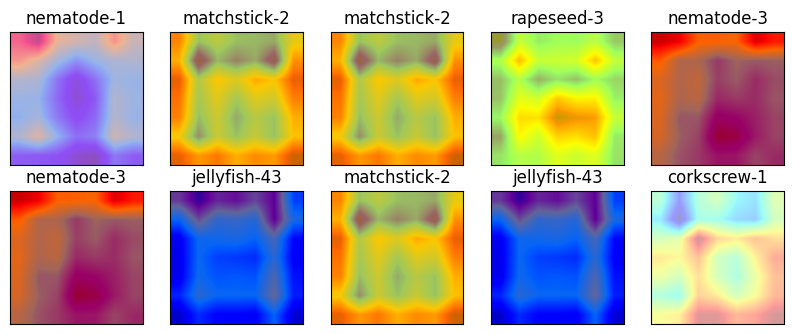

In [12]:

new_dataset = torchvision.datasets.ImageFolder(root='Noise/',transform=transform)
#image_dataset = torch.utils.data.ConcatDataset([imagenet_data, new_dataset])

#train1_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [0.8, 0.2])
train1_dataset, test_dataset = torch.utils.data.random_split(new_dataset, [0.8, 0.2])


data_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

import matplotlib.pyplot as plt
import numpy as np

# Initialize Figure
fig = plt.figure(figsize=(10,10), frameon=False)


# Iterate over the dataiter to produce a few examples

# Ensure model is eval mode to disable batch normalisation during inference.
model.eval()
j = 0
scaleFactor = HW_trg/7
for i in range(10):
    dataiter = iter(data_loader)

    
    z = next(dataiter)
    z_img = z[0].to(device)
    img = z[0]
   
    opFeatures,opLogits = getPrediction(z_img)
    topN = 1
    selectedClass = 0
    act_map_us,curr_class,curr_value = getCAM(opFeatures,opLogits,topN,selectedClass)
    
   
                             
 
    # N. Plotting

    def get_value(dictionary, key):
        try:
          return dictionary[key]
        except KeyError:
           return "Error " + str(key)

#    label = get_value(imagenette_dict,int(curr_class))
    label = get_value(imagenette_labels,int(curr_class)) + "-" + str(int(curr_value))
    ax = fig.add_subplot(5, 5, j + 1, xticks=[], yticks=[])
    ax.title.set_text(label)
    img=unnormalize_image(img,mean,std)
    ax.imshow(img)
    plt.imshow(img)
    plt.imshow(act_map_us.detach().numpy(), cmap=plt.cm.jet, alpha=0.4)
    j=j+1


plt.show()





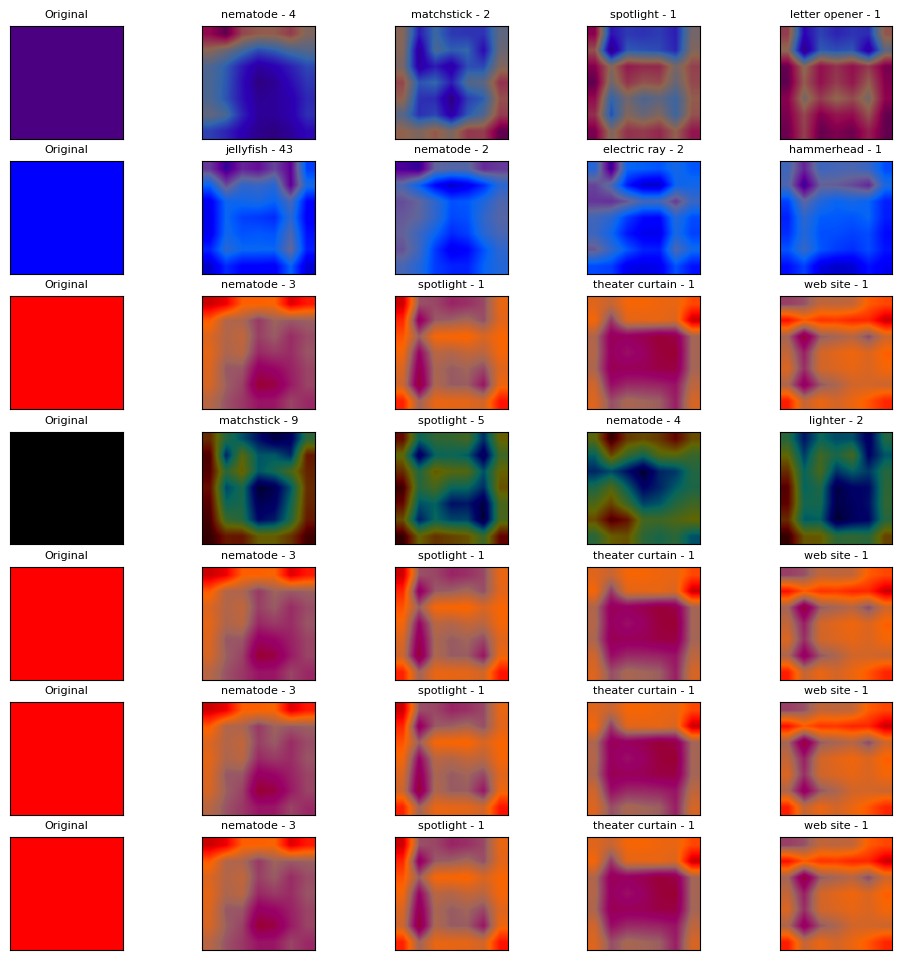

In [13]:
plot_cam ()

In [14]:
def generate_topDistr(rootDir,distrName,top_distribution,top5_distribution):
# ADDED - code added to iterate over a number of images and for each of those images generate a CAM based 
# on the top 5 predictions.
    new_dataset = torchvision.datasets.ImageFolder(root=rootDir,transform=transform)
#image_dataset = torch.utils.data.ConcatDataset([imagenet_data, new_dataset])
    image_labels = new_dataset.classes
    train1_dataset, test_dataset = torch.utils.data.random_split(new_dataset, [0.8, 0.2])
    data_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
    top_distribution,top5_distribution = generate_topn_distribution(top_distribution,top5_distribution,distrName,image_labels)

#plot_cam()
    return top_distribution,top5_distribution


In [ ]:
## Test 2 – Checking Pre-trained model with synthetic data.

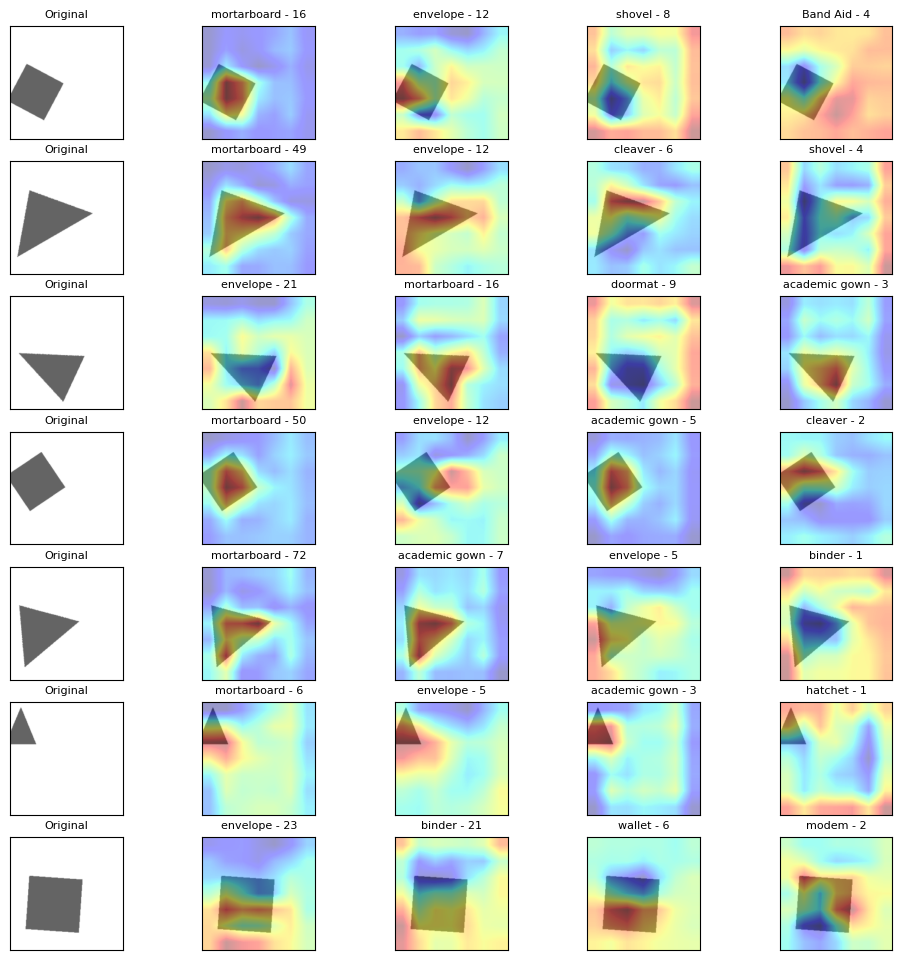

In [15]:
# ADDED - code added to iterate over a number of images and for each of those images generate a CAM based 
# on the top 5 predictions.
new_dataset = torchvision.datasets.ImageFolder(root='RealContent/',transform=transform)
#image_dataset = torch.utils.data.ConcatDataset([imagenet_data, new_dataset])

train1_dataset, test_dataset = torch.utils.data.random_split(new_dataset, [0.8, 0.2])
data_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
top_distribution = {}
top5_distribution = {}


plot_cam()
top_distribution,top5_distribution=generate_topDistr('RealContent/','Texture',top_distribution,top5_distribution)


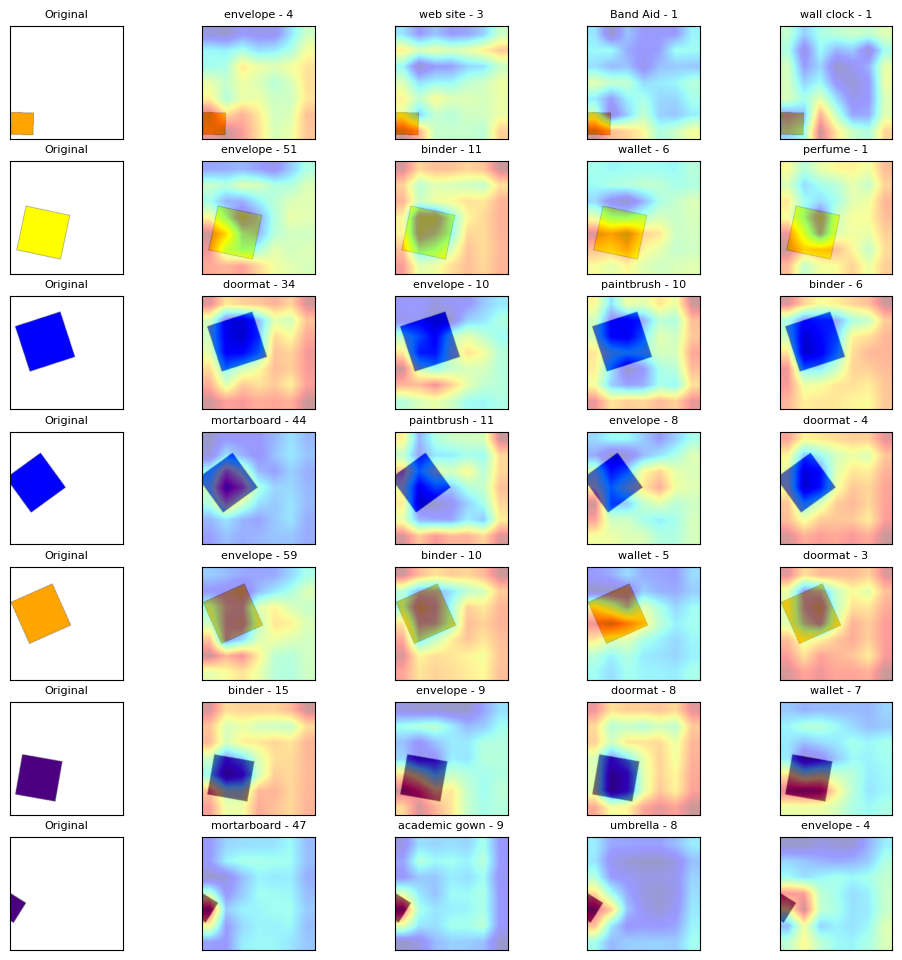

In [16]:
# ADDED - code added to iterate over a number of images and for each of those images generate a CAM based 
# on the top 5 predictions.
new_dataset = torchvision.datasets.ImageFolder(root='RealContentColour/',transform=transform)
#image_dataset = torch.utils.data.ConcatDataset([imagenet_data, new_dataset])

train1_dataset, test_dataset = torch.utils.data.random_split(new_dataset, [0.8, 0.2])
data_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

plot_cam()
top_distribution,top5_distribution=generate_topDistr('RealContentColour/','C_Texture',top_distribution,top5_distribution)


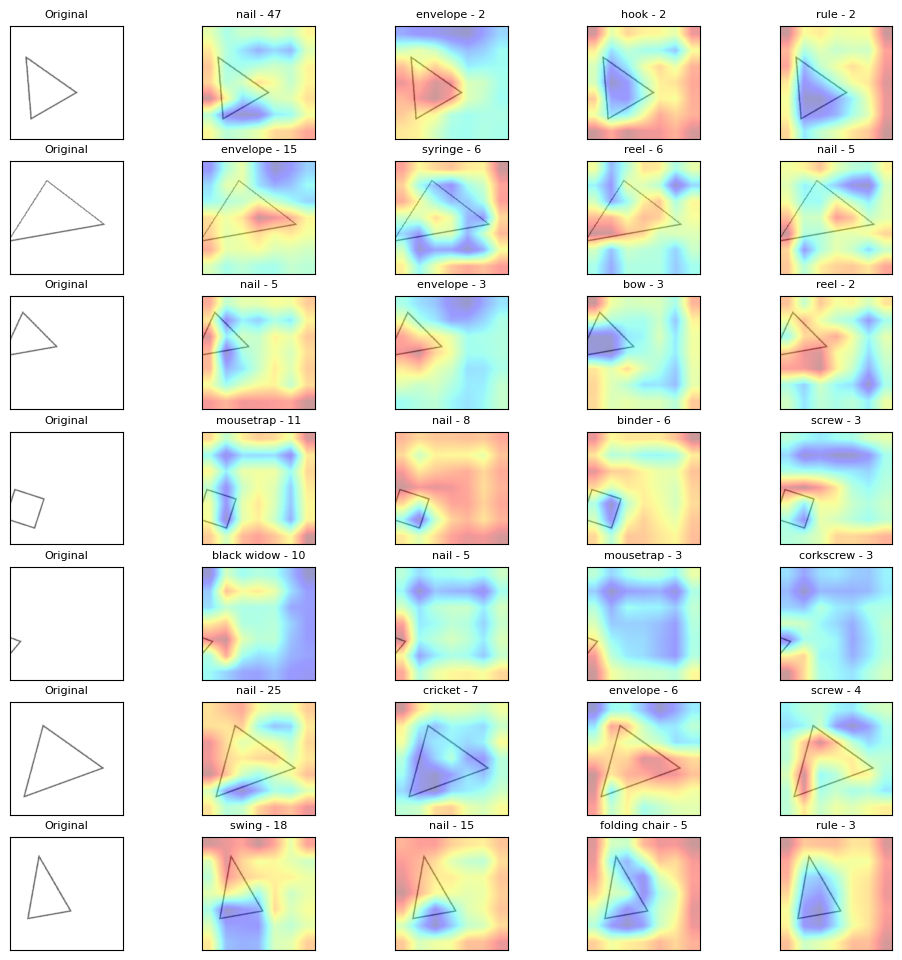

In [17]:
# ADDED - code added to iterate over a number of images and for each of those images generate a CAM based 
# on the top 5 predictions.
new_dataset = torchvision.datasets.ImageFolder(root='OutlineContent/',transform=transform)
#image_dataset = torch.utils.data.ConcatDataset([imagenet_data, new_dataset])

train1_dataset, test_dataset = torch.utils.data.random_split(new_dataset, [0.8, 0.2])
data_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

plot_cam()
#plot_cam_class('hook')
top_distribution,top5_distribution=generate_topDistr('OutlineContent/','Outline',top_distribution,top5_distribution)


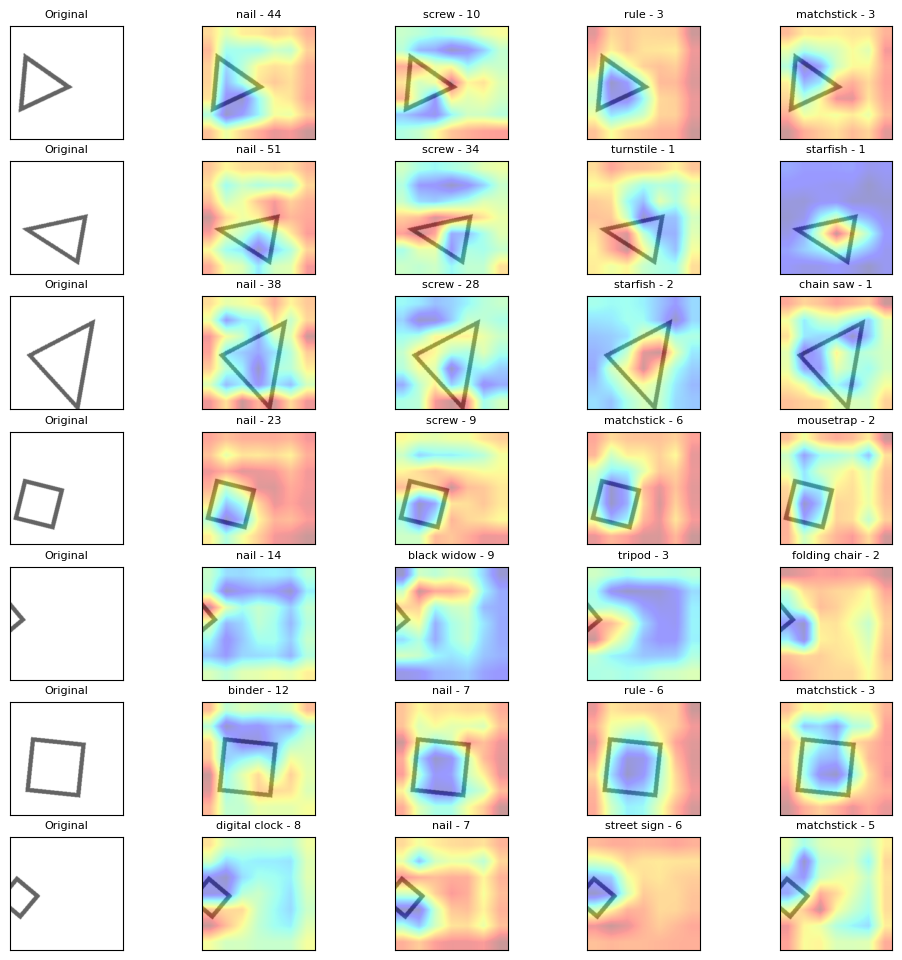

In [18]:
# ADDED - code added to iterate over a number of images and for each of those images generate a CAM based 
# on the top 5 predictions.
new_dataset = torchvision.datasets.ImageFolder(root='OutlineContentThick/',transform=transform)
#image_dataset = torch.utils.data.ConcatDataset([imagenet_data, new_dataset])

train1_dataset, test_dataset = torch.utils.data.random_split(new_dataset, [0.8, 0.2])
data_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

plot_cam()
top_distribution,top5_distribution=generate_topDistr('OutlineContentThick/','Th_Outline',top_distribution,top5_distribution)


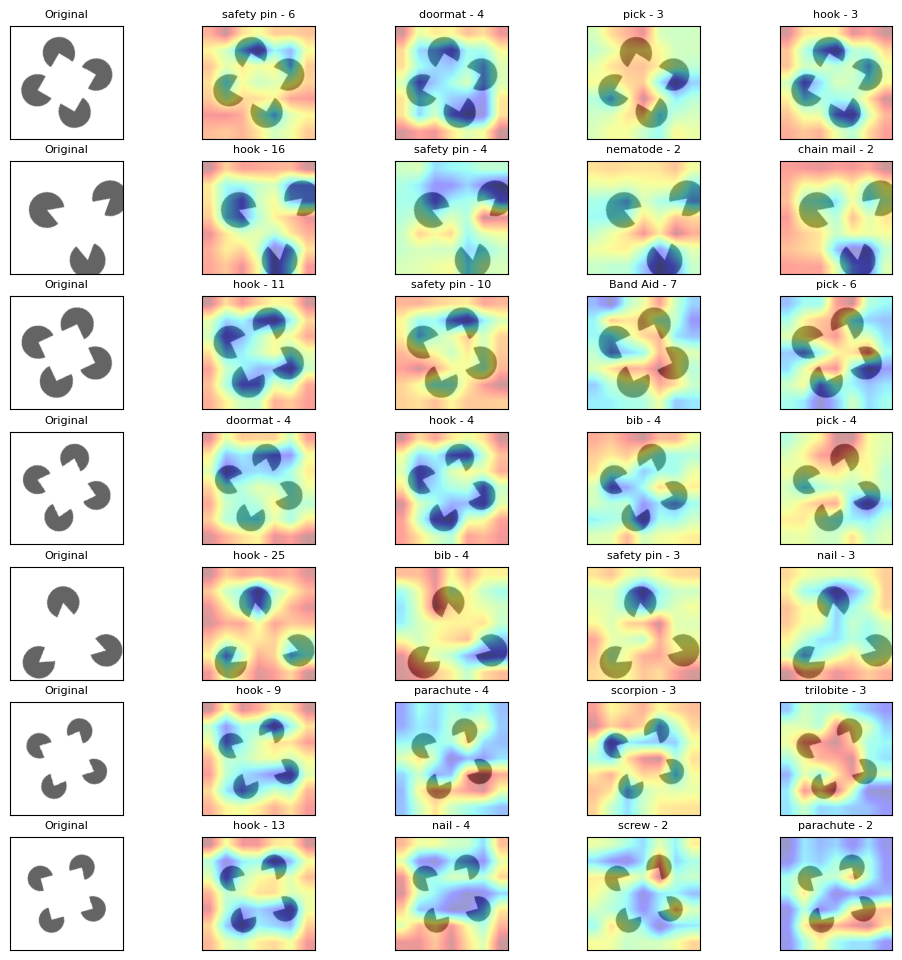

In [19]:
# ADDED - code added to iterate over a number of images and for each of those images generate a CAM based 
# on the top 5 predictions.
new_dataset = torchvision.datasets.ImageFolder(root='Kanizsa/',transform=transform)
#image_dataset = torch.utils.data.ConcatDataset([imagenet_data, new_dataset])

train1_dataset, test_dataset = torch.utils.data.random_split(new_dataset, [0.8, 0.2])
data_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

plot_cam()
top_distribution,top5_distribution=generate_topDistr('Kanizsa/','Kanizsa',top_distribution,top5_distribution)


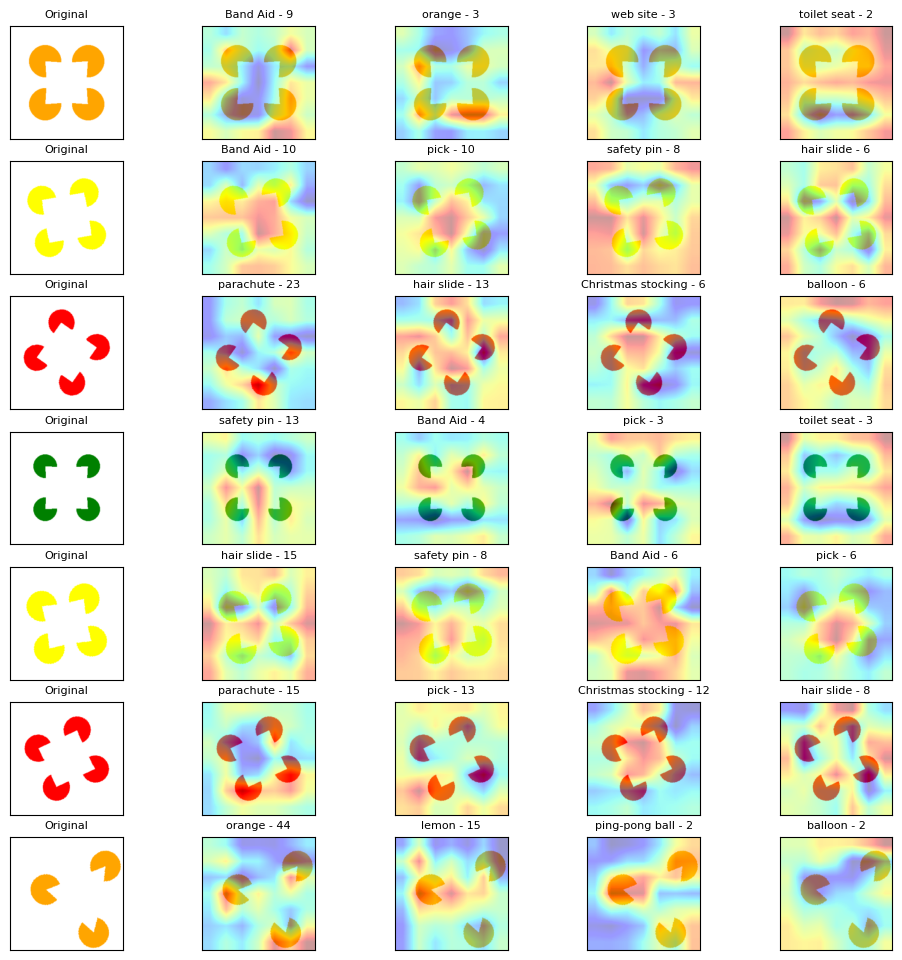

In [20]:
# ADDED - code added to iterate over a number of images and for each of those images generate a CAM based 
# on the top 5 predictions.
new_dataset = torchvision.datasets.ImageFolder(root='KanizsaRed/',transform=transform)
#image_dataset = torch.utils.data.ConcatDataset([imagenet_data, new_dataset])

train1_dataset, test_dataset = torch.utils.data.random_split(new_dataset, [0.8, 0.2])
data_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

plot_cam()
top_distribution,top5_distribution=generate_topDistr('KanizsaRed/','C_Kanizsa',top_distribution,top5_distribution)


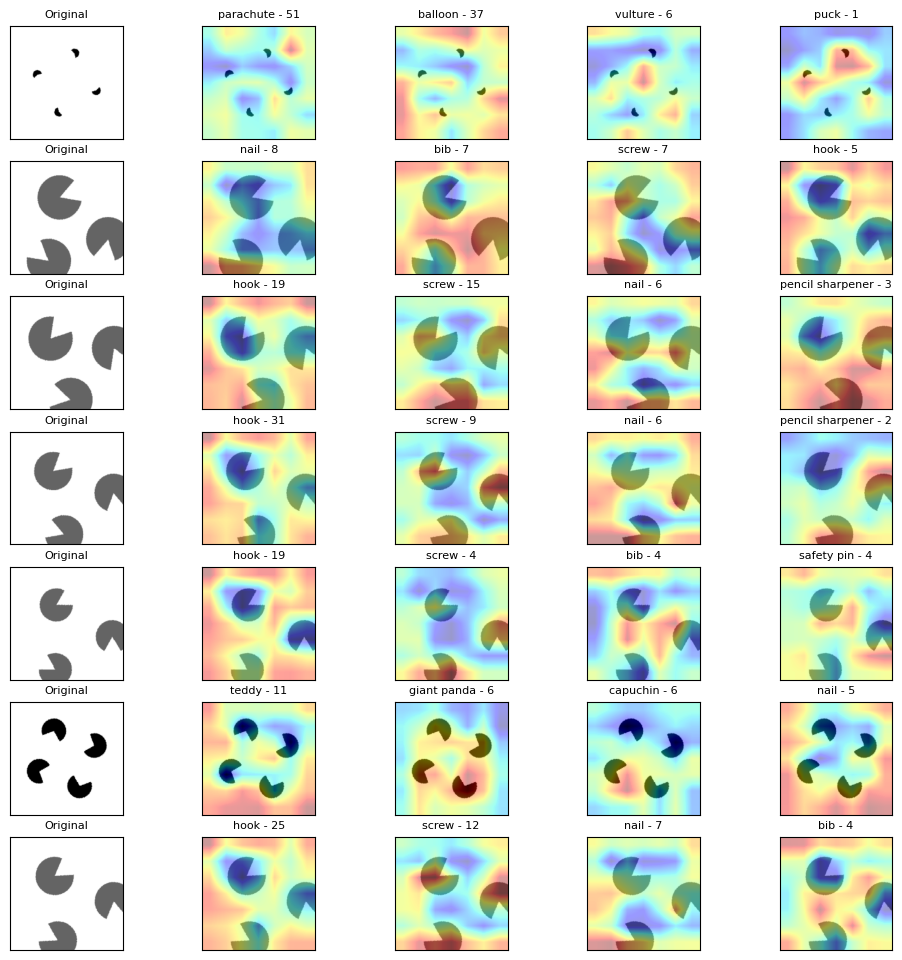

In [21]:
# ADDED - code added to iterate over a number of images and for each of those images generate a CAM based 
# on the top 5 predictions.
new_dataset = torchvision.datasets.ImageFolder(root='NotKanizsa/',transform=transform)
#image_dataset = torch.utils.data.ConcatDataset([imagenet_data, new_dataset])

train1_dataset, test_dataset = torch.utils.data.random_split(new_dataset, [0.8, 0.2])
data_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

plot_cam()
top_distribution,top5_distribution=generate_topDistr('NotKanizsa/','N_Kanizsa',top_distribution,top5_distribution)


In [22]:
df=pd.DataFrame.from_dict(top_distribution,orient='index')
df = df.replace(np.nan,0)
df.sort_values(by=['Texture'],ascending=False)

,Texture,C_Texture,Outline,Th_Outline,N_Kanizsa,C_Kanizsa,Kanizsa
mortarboard,465.0,110.0,0.0,0.0,9.0,0.0,0.0
envelope,225.0,245.0,53.0,0.0,0.0,1.0,0.0
binder,119.0,17.0,98.0,5.0,0.0,0.0,0.0
wallet,14.0,4.0,0.0,0.0,0.0,0.0,0.0
hatchet,4.0,0.0,0.0,0.0,0.0,0.0,0.0
doormat,3.0,29.0,0.0,70.0,0.0,0.0,0.0
loudspeaker,2.0,0.0,0.0,0.0,0.0,0.0,0.0
soccer ball,0.0,0.0,0.0,0.0,1.0,0.0,0.0
vulture,0.0,0.0,0.0,0.0,23.0,0.0,0.0
ostrich,0.0,0.0,0.0,0.0,10.0,0.0,0.0


In [23]:
top_distribution = {}
top5_distribution = {}
top_distribution,top5_distribution=generate_topDistr('RealContent/','Texture',top_distribution,top5_distribution)
top_distribution,top5_distribution=generate_topDistr('RealContentColour/','C_Texture',top_distribution,top5_distribution)
top_distribution,top5_distribution=generate_topDistr('OutlineContent/','Outline',top_distribution,top5_distribution)
top_distribution,top5_distribution=generate_topDistr('OutlineContentThick/','Th_Outline',top_distribution,top5_distribution)
top_distribution,top5_distribution=generate_topDistr('Kanizsa/','Kanizsa',top_distribution,top5_distribution)
top_distribution,top5_distribution=generate_topDistr('KanizsaRed/','C_Kanizsa',top_distribution,top5_distribution)
top_distribution,top5_distribution=generate_topDistr('NotKanizsa/','N_Kanizsa',top_distribution,top5_distribution)



In [24]:
df=pd.DataFrame.from_dict(top_distribution,orient='index')
df = df.replace(np.nan,0)
df.sort_values(by=['C_Texture'],ascending=False)

,Texture,C_Texture,Outline,Th_Outline,Kanizsa,C_Kanizsa,N_Kanizsa
teddy,104,96.0,97.0,104.0,96.0,100.0,97.0
parachute,90,85.0,88.0,85.0,88.0,96.0,90.0
hook,417,77.0,91.0,72.0,75.0,82.0,78.0
puck,39,41.0,38.0,32.0,34.0,35.0,38.0
balloon,19,29.0,25.0,21.0,27.0,27.0,25.0
giant panda,25,20.0,20.0,22.0,12.0,23.0,17.0
sea urchin,15,18.0,11.0,23.0,10.0,21.0,13.0
vulture,26,17.0,15.0,21.0,22.0,29.0,28.0
nail,10,12.0,11.0,18.0,18.0,13.0,16.0
kite,2,9.0,5.0,4.0,6.0,6.0,6.0


In [25]:
pd.set_option('display.max_rows', 200)
df = pd.DataFrame.from_dict(top5_distribution,orient='index')
df = df.replace(np.nan,0)
df.sort_values(by=['Texture'],ascending=False)

,Texture,C_Texture,Outline,Th_Outline,Kanizsa,C_Kanizsa,N_Kanizsa
hook,470,123.0,121.0,127.0,113.0,122.0,133.0
teddy,179,186.0,171.0,183.0,161.0,197.0,178.0
parachute,146,143.0,140.0,140.0,147.0,158.0,148.0
puck,99,92.0,90.0,90.0,98.0,92.0,97.0
balloon,77,90.0,83.0,82.0,95.0,82.0,92.0
giant panda,66,59.0,51.0,65.0,35.0,70.0,55.0
screw,66,1.0,7.0,4.0,3.0,4.0,0.0
vulture,60,52.0,47.0,51.0,65.0,70.0,74.0
nail,52,53.0,53.0,58.0,52.0,45.0,51.0
bib,44,0.0,0.0,0.0,0.0,0.0,0.0
